# Gym.Mountain-Car

AAC решение

[https://pylessons.com/A2C-reinforcement-learning](https://pylessons.com/A2C-reinforcement-learning)

In [ ]:
# !pip install "gym[atari, accept-rom-license]"

# ! wget http://www.atarimania.com/roms/Roms.rar
# ! mkdir /content/ROM/
# ! unrar e /content/Roms.rar /content/ROM/
# ! python -m atari_py.import_roms /content/ROM/

In [1]:
import os
import random
import gym
import numpy as np
from collections import deque

from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda, Add, Conv2D, Flatten
from keras.optimizers import Adam, RMSprop
from keras import backend as K

import tensorflow as tf
from tensorflow.keras.regularizers import *  # Импортируем все регуляризаторы кераса

import pylab
import matplotlib.pyplot as plt
# import cv2

import time

from tensorflow.keras import utils 

## Свойства среды

In [2]:
# Import and initialize Mountain Car Environment
env_name = 'MountainCar-v0'
env = gym.make(env_name) #, render_mode="human")
state = env.reset()

from gym.utils.env_checker import check_env
check_env(env)

#### обзор свойств

In [25]:
print('State space:', env.observation_space)
print('Action space:', env.action_space)

# Границы пространств
print(f'{env.observation_space.shape=}')
# print(f'{env.observation_space.high=}, {env.observation_space.low=}')
# рабочий интервал
print(f'{(env.observation_space.high - env.observation_space.low)=}')

State space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space: Discrete(3)
env.observation_space.shape=(2,)
env.observation_space.high=array([0.6 , 0.07], dtype=float32), env.observation_space.low=array([-1.2 , -0.07], dtype=float32)
(env.observation_space.high - env.observation_space.low)=array([1.8000001, 0.14     ], dtype=float32)


In [26]:
# преобразование observation_space к сокращенному размерности
print((env.observation_space.high - env.observation_space.low) * np.array([10, 100]))
num_states =np.round((env.observation_space.high - env.observation_space.low) * np.array([10, 100]), 0).astype(int) + 1
print(f'{num_states=}')

[18.00000072 14.00000006]
num_states=array([19, 15])


In [ ]:
print(env.reset())

state = env.reset()
env.render()
print(type(state), state)
print(type(env.observation_space.low),env.observation_space.low)
print()

In [24]:
# Приведение значений состояния
state_adj = (state - env.observation_space.low)*np.array([10, 100])
state_adj = np.round(state_adj, 0).astype(int)+1
print(state_adj)

State space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space: Discrete(3)
env.observation_space.shape=(2,)
env.observation_space.high=array([0.6 , 0.07], dtype=float32), env.observation_space.low=array([-1.2 , -0.07], dtype=float32)

[18.00000072 14.00000006]
num_states=array([19, 15])
<class 'numpy.ndarray'> [-0.5482435  0.       ]
<class 'numpy.ndarray'> [-1.2  -0.07]

[8 8]


In [4]:
# # env = gym.make('MountainCar-v0')
# env = gym.make('PongDeterministic-v4')
# env.reset()
# ap = env.step(1)a
# np.array(ap).shape

In [5]:
# Дискретизация состояния
def adjust_state(state):
    st_adj = (state - env.observation_space.low)*np.array([10, 100])
    st_adj = np.round(st_adj, 0).astype(int) 
    return st_adj

In [6]:
# rstate = env.reset()
# nrstate = adjust_state(rstate)
# print(rstate, nrstate, '\n')

print(env.step(2))
nstate, reward, done, info = env.step(2)
astate = adjust_state(nstate)
print(nstate, reward, done, info, astate)
num_state = adjust_state(env.observation_space.high)
num_state = np.round(num_state, 0).astype(int)+1
print(num_state, num_state.shape)

(array([-0.45109937,  0.00046393], dtype=float32), -1.0, False, {})
[-0.45017493  0.00092446] -1.0 False {} [7 7]
[19 15] (2,)


## Код

In [2]:
#Функция отображения наград за эпизод
def show_scores(scores, episode_durations):
  
  #   output.clear()  # Удаляем предыдущий вывод ячейки
  # Устанавливаем большой размер полотна
  fig, axes = plt.subplots(1, 2, figsize = (20, 8))
  # Отрисовываем награды
  axes[0].plot(scores, linestyle = '--', label = 'Награда за эпизод')
  # Считаем и отрисовываем скользящее среднее от награды
  axes[0].plot(moving_average(scores), label = 'Скользящее среднее награды')
  # Добавляем метки осей
  axes[0].set_xlabel('Эпизод', fontsize = 12)
  axes[0].set_ylabel('Награда', fontsize = 12)

  # обозначения
  axes[0].legend()

  # Отрисовываем длину эпизодов
  axes[1].plot(episode_durations, 'r', linestyle = '--', label = 'Длина эпизода (количество действий)')
  # Считаем и отрисовываем скользящее среднее по длины эпизода
  axes[1].plot(moving_average(episode_durations), 'k', label = 'Длина эпизода (Скользящее среднее)')
  # Добавляем метки осей
  axes[1].set_xlabel('Эпизод', fontsize = 12)
  axes[1].set_ylabel('Количество действий', fontsize = 12)
  axes[1].legend()    #обозначения

  # Выводим график
  plt.show()

# функцию для подсчета скользящего среднего всех значений
def moving_average(data, width = 50): #data — входной массив, width — длина, на которую считаем скользящее среднее
    width = min(width, len(data))       #Длина свертки (минимум из заданной длины свертки и длины датасета)
    # Вместо паддинга из нулей мы создадим паддинг для свертки из первого значения массива. Весь паддинг будет слева (в начале массива)
    data = np.concatenate([np.repeat(data[0], width), data])         
    # Возвращаем результат свертки данных на фильтр из единиц — наше скользящее среднее
    return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  


#### Модель

In [3]:
def A2CModel(input_shape, action_space, lr):  ## возвращает созданные Actor, Critic
    X_input = Input(input_shape)

    #X = Conv2D(32, 8, strides=(4, 4),padding="valid", activation="elu", data_format="channels_first", input_shape=input_shape)(X_input)
    #X = Conv2D(64, 4, strides=(2, 2),padding="valid", activation="elu", data_format="channels_first")(X)
    #X = Conv2D(64, 3, strides=(1, 1),padding="valid", activation="elu", data_format="channels_first")(X)
    X = Flatten(input_shape=input_shape)(X_input)

    X = Dense(512, activation="elu", kernel_initializer='he_uniform')(X)
    #X = Dense(256, activation="elu", kernel_initializer='he_uniform')(X)
    #X = Dense(64, activation="elu", kernel_initializer='he_uniform')(X)

    action = Dense(action_space, activation="softmax", kernel_initializer='he_uniform')(X)
    value = Dense(1, kernel_initializer='he_uniform')(X)

    Actor = Model(inputs = X_input, outputs = action)
    Actor.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=lr))

    Critic = Model(inputs = X_input, outputs = value)
    Critic.compile(loss='mse', optimizer=RMSprop(learning_rate=lr))
    
#     utils.plot_model(Actor,dpi=60)

    return Actor, Critic

#### Агент

In [6]:
class A2CAgent:
    # Actor-Critic Main Optimization Algorithm
    def __init__(self, env_name):
        # Initialization
        # Environment and PPO parameters
        self.env_name = env_name
        self.env = gym.make(env_name)
        self.action_size = self.env.action_space.n
        self.EPISODES = 10000
        self.max_average =  -200.0 # specific for pong
        self.lr = 0.000025
        self.gamma = .98
        # Instantiate games and plot memory
        self.states, self.actions, self.rewards = [], [], []
        self.scores, self.episodes, self.average = [], [], []
        self.durations = []

        self.state_size = self.env.observation_space.shape[0]
        #         self.state_size = (self.REM_STEP, self.ROWS, self.COLS)
        #         self.image_memory = np.zeros(self.state_size)

        self.Save_Path = 'Models'
        if not os.path.exists(self.Save_Path): os.makedirs(self.Save_Path)
        self.path = '{}_A2C_{}'.format(self.env_name, self.lr)
        self.Model_name = os.path.join(self.Save_Path, self.path)
        #------- check ---------
        print(self.Model_name)
        print(f'{self.action_size=}')
        print(f'{self.env.observation_space.shape=}')
        print(f'{self.state_size=}')
        # ----------------------
        # Create Actor-Critic network model
        self.Actor, self.Critic = A2CModel(input_shape=(self.env.observation_space.shape[0],),
                                           action_space = self.action_size, lr=self.lr)

    def remember(self, state, action, reward):
        # store episode actions to memory
        self.states.append(state)
        action_onehot = np.zeros([self.action_size])
        action_onehot[action] = 1
        self.actions.append(action_onehot)
        self.rewards.append(reward)


    def act(self, state):
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.predict(state, verbose=0)[0]
        # ------- check --------
        # print(state)
        # print(prediction)
        # ----------------------
        action = np.random.choice(self.action_size, p=prediction)
        return action

    def discount_rewards(self, reward):
        # Compute the gamma-discounted rewards over an episode
        gamma = 0.98    # discount rate
        running_add = 0

        discounted_r = np.zeros_like(reward)
        for i in reversed(range(0,len(reward))):
            # !!!            if reward[i] != 0: # reset the sum, since this was a game boundary (pong specific!)
            # !!!                running_add = 0
            running_add = running_add * gamma + reward[i]
            discounted_r[i] = running_add
        # ------- check --------
        # print(f'{len(reward)=}, \n {reward=}')
        # print(f'{discounted_r=}, {np.mean(discounted_r)=}, {np.std(discounted_r)=}' )

        discounted_r -= np.mean(discounted_r) # normalizing the result
        discounted_r /= np.std(discounted_r)  # divide by standard deviation
        return discounted_r


    def replay(self):
        # reshape memory to appropriate shape for training
        states = np.vstack(self.states)
        actions = np.vstack(self.actions)
        #         print(states)

        # Compute discounted rewards
        discounted_r = self.discount_rewards(self.rewards)
        # ------- Check ---------
        # print(self.rewards[:9])
        # print(discounted_r[:9])

        # Get Critic network predictions
        values = self.Critic.predict(states, verbose=0)[:, 0]  #, verbose=0
        # ------- Check ---------
        # print(f'{values[:9]=}')

        # Compute advantages
        advantages = discounted_r - values
        # print(f'{advantages[:9]=}')
        
        # training Actor and Critic networks
        self.Actor.fit(states, actions, sample_weight=advantages, epochs=3, verbose=0)
        self.Critic.fit(states, discounted_r, epochs=3, verbose=0)

        # reset training memory
        self.states, self.actions, self.rewards = [], [], []

    def load(self, Actor_name, Critic_name):
        self.Actor = load_model(Actor_name, compile=False)
        #self.Critic = load_model(Critic_name, compile=False)

    def save(self):
        self.Actor.save(self.Model_name + '_Actor.h5')
        #self.Critic.save(self.Model_name + '_Critic.h5')

    pylab.figure(figsize=(18, 9))
    def PlotModel(self, score, episode, duration):
        self.scores.append(score)
        self.episodes.append(episode)
        self.durations.append(duration)
        
        self.average.append(sum(self.scores[-50:]) / len(self.scores[-50:]))
        if episode%50 == 0 and episode > 0: 
            show_scores(self.scores, self.durations) 
            
        if str(episode)[-2:] == "00": # much faster than episode % 100
            pylab.plot(self.episodes, self.scores, 'b')
            pylab.plot(self.episodes, self.average, 'r')
            pylab.ylabel('Score', fontsize=18)
            pylab.xlabel('Steps', fontsize=18)
            try:
                pylab.savefig(self.path+".png")
            except OSError:
                pass
        return self.average[-1]

    def step(self, action):
        next_state, reward, done, info = self.env.step(action)
        return next_state, reward, done, info

    def reset(self):
        state = self.env.reset()
        return state

    def run(self, episod_num):
        self.EPISODES = min(self.EPISODES, episod_num)

        for e in range(self.EPISODES):
            state = self.reset()
            state = np.reshape(state, [1, self.state_size])
            done, score, SAVING = False, 0, ''
            duration = 0
            
            while not done:
                #self.env.render()
                # Actor picks an action
                action = self.act(state)

                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                # ------- check ------
                # print(next_state)
                
                if not done:
#                     reward = 1000 * (abs(next_state[0][1]) - abs(state[0][1]))  
#                     reward = reward + 15 * (abs(next_state[0][1]) - abs(state[0][1]))  
                    reward = 1000 * abs(next_state[0][1])
                else:
                    if next_state[0][0] >= .5 :
                        reward = 2000
                    else:
                        reward = 0
                        
                # Memorize (state, action, reward) for training
                self.remember(state, action, reward)

                # Update current state
                state = next_state
                score += reward
                duration += 1
                if done:
                    average = self.PlotModel(score, e, duration)
                    # saving best models
                    if average >= self.max_average and e > 30:
                        self.max_average = average
                        self.save()
                        SAVING = "SAVING"
                    else:
                        SAVING = ""

                    print("episode: {}/{}, score: {}, dur: {}, average: {:.2f} {}".format(e, self.EPISODES, score, duration, average, SAVING))
                    
                    self.replay()
        # close environemnt when finish training
        self.env.close()

    def test(self, Actor_name, Critic_name):
        self.load(Actor_name, Critic_name)
        for e in range(100):
            state = self.reset()
            done = False
            score = 0
            while not done:
                action = np.argmax(self.Actor.predict(state))
                state, reward, done, _ = self.step(action)
                score += reward
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, score))
                    break
        self.env.close()

<Figure size 1800x900 with 0 Axes>

## Обучение

In [7]:
env_name = 'MountainCar-v0'

agent = A2CAgent(env_name)

print(agent.Actor.summary())

Models\MountainCar-v0_A2C_2.5e-05
self.action_size=3
self.env.observation_space.shape=(2,)
self.state_size=2
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 flatten (Flatten)           (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 512)               1536      
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 3,075
Trainable params: 3,075
Non-trainable params: 0
_________________________________________________________________
None


episode: 0/1500, score: 1001.3924517879786, dur: 200, average: 1001.39 
episode: 1/1500, score: 1418.4617563441861, dur: 200, average: 1209.93 
episode: 2/1500, score: 1130.0078182379139, dur: 200, average: 1183.29 
episode: 3/1500, score: 727.5561594724422, dur: 200, average: 1069.35 
episode: 4/1500, score: 1392.7235769095319, dur: 200, average: 1134.03 
episode: 5/1500, score: 1036.1409958622971, dur: 200, average: 1117.71 
episode: 6/1500, score: 1103.6406951534445, dur: 200, average: 1115.70 
episode: 7/1500, score: 1296.9192029522674, dur: 200, average: 1138.36 
episode: 8/1500, score: 603.6623561230954, dur: 200, average: 1078.95 
episode: 9/1500, score: 777.4358325841604, dur: 200, average: 1048.79 
episode: 10/1500, score: 1281.2384188146098, dur: 200, average: 1069.93 
episode: 11/1500, score: 1198.6266381263704, dur: 200, average: 1080.65 
episode: 12/1500, score: 610.8837279193722, dur: 200, average: 1044.51 
episode: 13/1500, score: 1382.0087587700982, dur: 200, average: 1

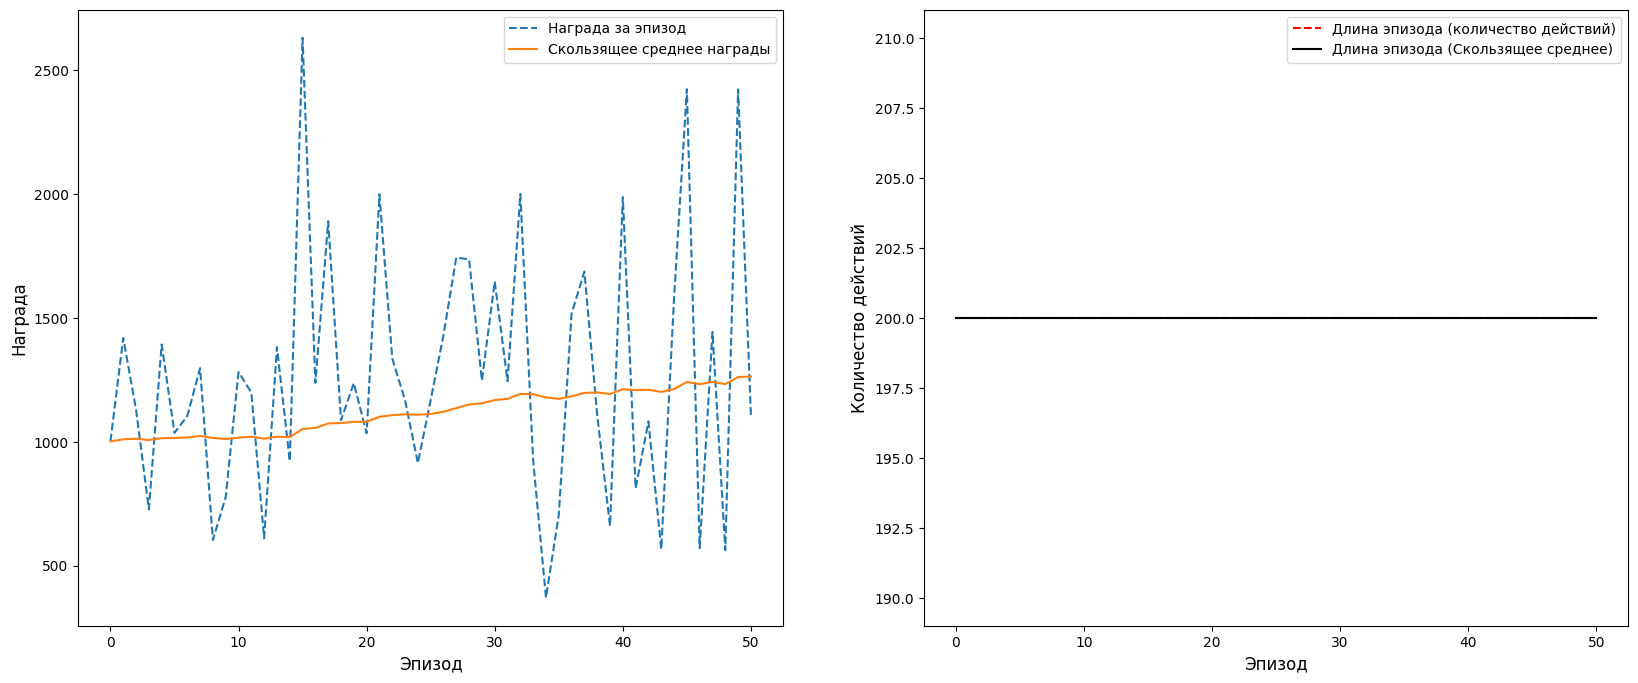

episode: 50/1500, score: 1108.5688884668343, dur: 200, average: 1263.11 
episode: 51/1500, score: 2498.931174435711, dur: 200, average: 1284.72 
episode: 52/1500, score: 759.4483856901206, dur: 200, average: 1277.31 
episode: 53/1500, score: 631.9738044599035, dur: 200, average: 1275.39 
episode: 54/1500, score: 535.4590885181096, dur: 200, average: 1258.25 
episode: 55/1500, score: 2014.9072501808405, dur: 200, average: 1277.82 
episode: 56/1500, score: 1712.4418721314214, dur: 200, average: 1290.00 
episode: 57/1500, score: 2310.421775953728, dur: 200, average: 1310.27 SAVING
episode: 58/1500, score: 515.5658044459415, dur: 200, average: 1308.51 
episode: 59/1500, score: 1272.269780638453, dur: 200, average: 1318.41 SAVING
episode: 60/1500, score: 880.1130768242729, dur: 200, average: 1310.38 
episode: 61/1500, score: 1502.5976684482885, dur: 200, average: 1316.46 
episode: 62/1500, score: 2220.491117500387, dur: 200, average: 1348.65 SAVING
episode: 63/1500, score: 2976.634426711825

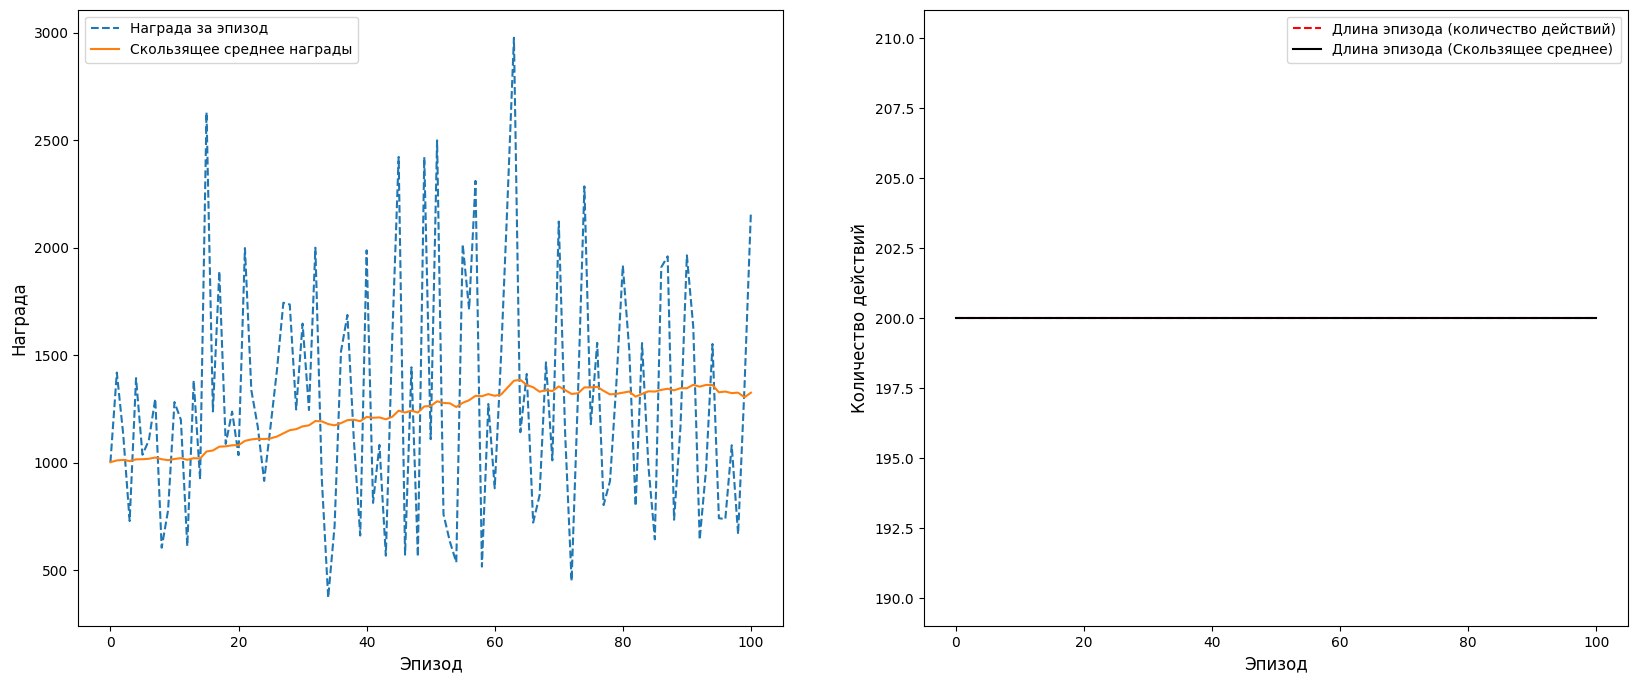

episode: 100/1500, score: 2168.9695702516474, dur: 200, average: 1324.88 
episode: 101/1500, score: 1900.203907614923, dur: 200, average: 1312.91 
episode: 102/1500, score: 992.125846863928, dur: 200, average: 1317.56 
episode: 103/1500, score: 850.5642505188007, dur: 200, average: 1321.94 
episode: 104/1500, score: 521.756146574262, dur: 200, average: 1321.66 
episode: 105/1500, score: 1481.5799036186945, dur: 200, average: 1310.99 
episode: 106/1500, score: 1483.3974773646332, dur: 200, average: 1306.41 
episode: 107/1500, score: 2299.170869664522, dur: 200, average: 1306.19 
episode: 108/1500, score: 696.8891701544635, dur: 200, average: 1309.82 
episode: 109/1500, score: 1786.3231962492137, dur: 200, average: 1320.10 
episode: 110/1500, score: 1753.4271066433575, dur: 200, average: 1337.56 
episode: 111/1500, score: 971.4858331572032, dur: 200, average: 1326.94 
episode: 112/1500, score: 1657.875373159186, dur: 200, average: 1315.69 
episode: 113/1500, score: 2112.358591897646, dur

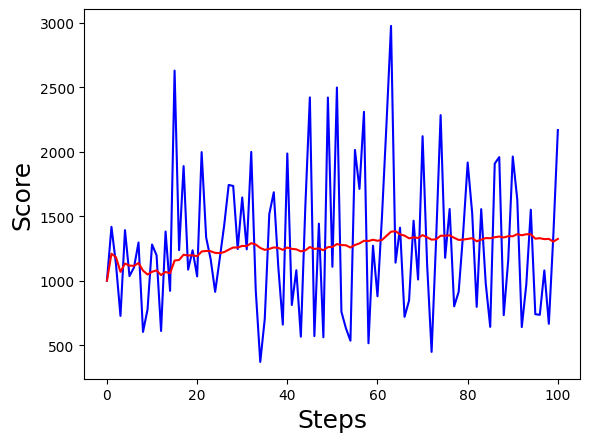

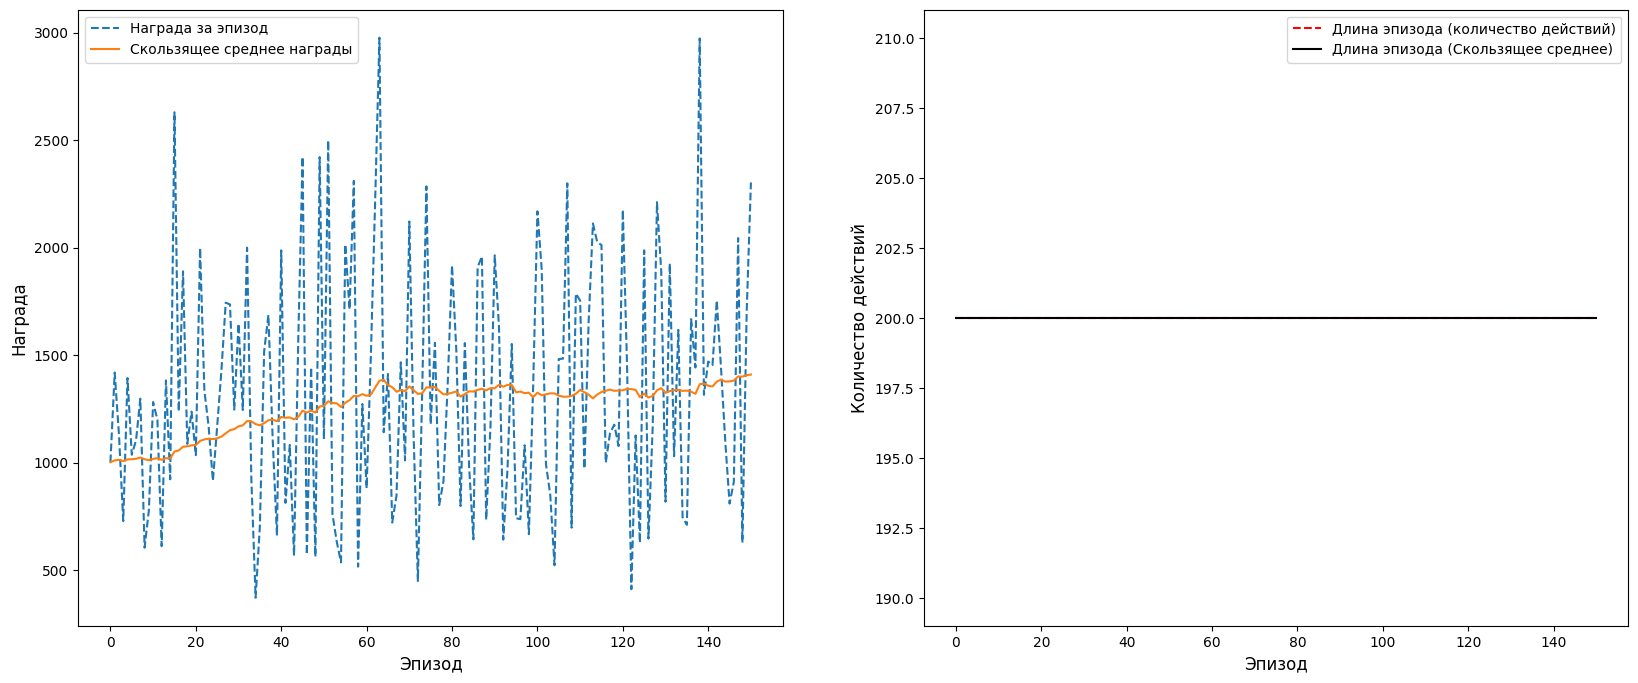

episode: 150/1500, score: 2303.20006646798, dur: 200, average: 1409.21 SAVING
episode: 151/1500, score: 2044.7349368491814, dur: 200, average: 1412.10 SAVING
episode: 152/1500, score: 1487.3631183072575, dur: 200, average: 1422.00 SAVING
episode: 153/1500, score: 1835.7132572673436, dur: 200, average: 1441.70 SAVING
episode: 154/1500, score: 1929.4312323709164, dur: 200, average: 1469.86 SAVING
episode: 155/1500, score: 1569.0471225434521, dur: 200, average: 1471.61 SAVING
episode: 156/1500, score: 539.6560060621596, dur: 200, average: 1452.73 
episode: 157/1500, score: 1229.4004034210957, dur: 200, average: 1431.34 
episode: 158/1500, score: 1910.1931890181731, dur: 200, average: 1455.60 
episode: 159/1500, score: 588.9613005892897, dur: 200, average: 1431.66 
episode: 160/1500, score: 1529.3040243341238, dur: 200, average: 1427.17 
episode: 161/1500, score: 1056.103033333784, dur: 200, average: 1428.87 
episode: 162/1500, score: 476.0788656949444, dur: 200, average: 1405.23 
episode:

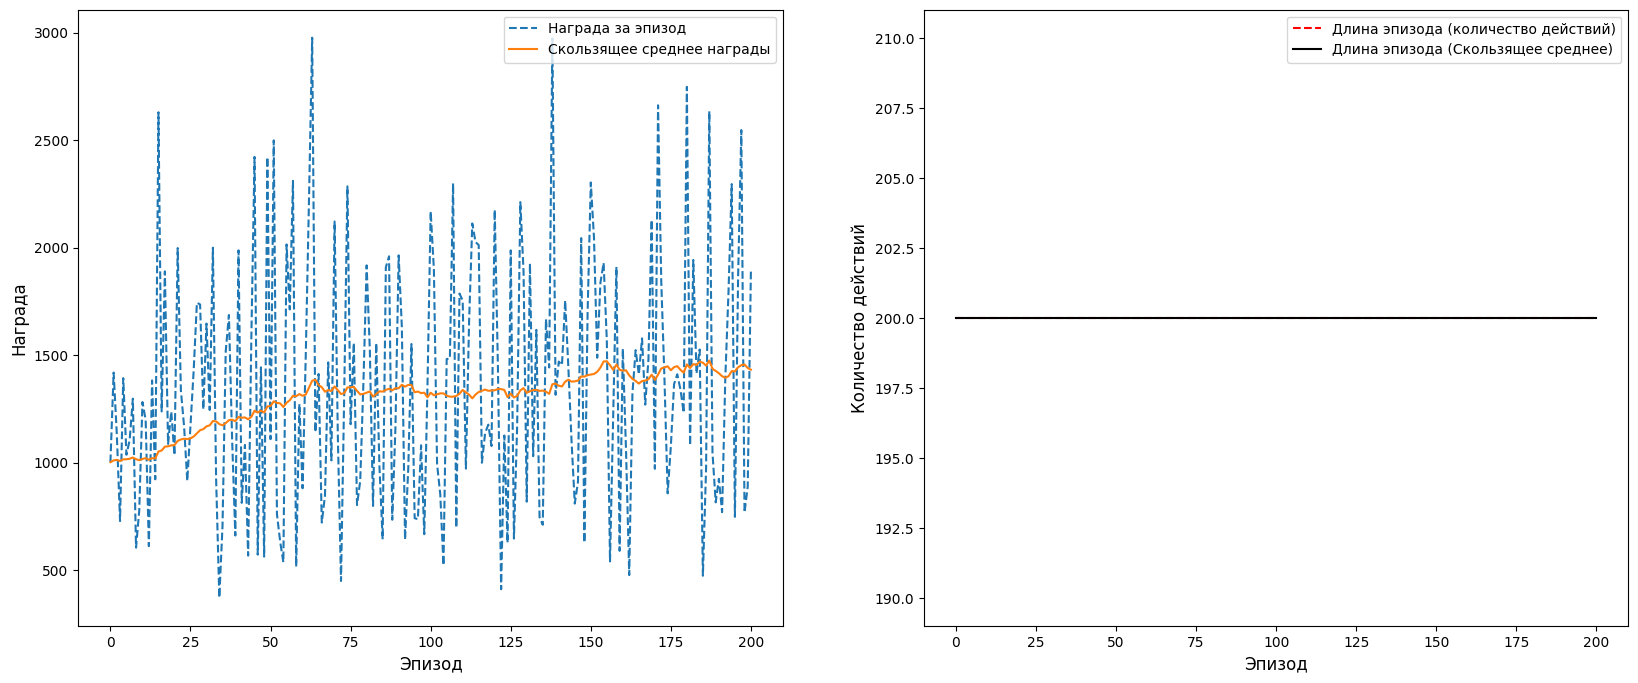

episode: 200/1500, score: 1897.8555221765419, dur: 200, average: 1431.77 
episode: 201/1500, score: 328.72992887860164, dur: 200, average: 1397.45 
episode: 202/1500, score: 1402.2500737773953, dur: 200, average: 1395.75 
episode: 203/1500, score: 1299.4823356275447, dur: 200, average: 1385.02 
episode: 204/1500, score: 787.0093851543061, dur: 200, average: 1362.17 
episode: 205/1500, score: 2037.9146153572947, dur: 200, average: 1371.55 
episode: 206/1500, score: 807.1901374245272, dur: 200, average: 1376.90 
episode: 207/1500, score: 1996.9567487532913, dur: 200, average: 1392.25 
episode: 208/1500, score: 537.4863075849134, dur: 200, average: 1364.80 
episode: 209/1500, score: 1097.3457899035566, dur: 200, average: 1374.97 
episode: 210/1500, score: 698.769544703282, dur: 200, average: 1358.35 
episode: 211/1500, score: 1929.2882920854026, dur: 200, average: 1375.82 
episode: 212/1500, score: 2190.2054982056143, dur: 200, average: 1410.10 
episode: 213/1500, score: 1906.807482533622

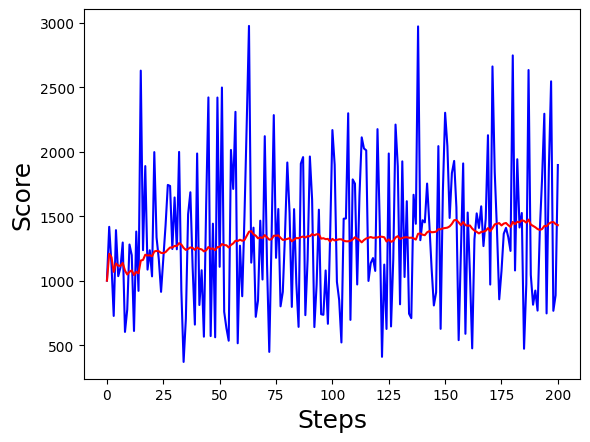

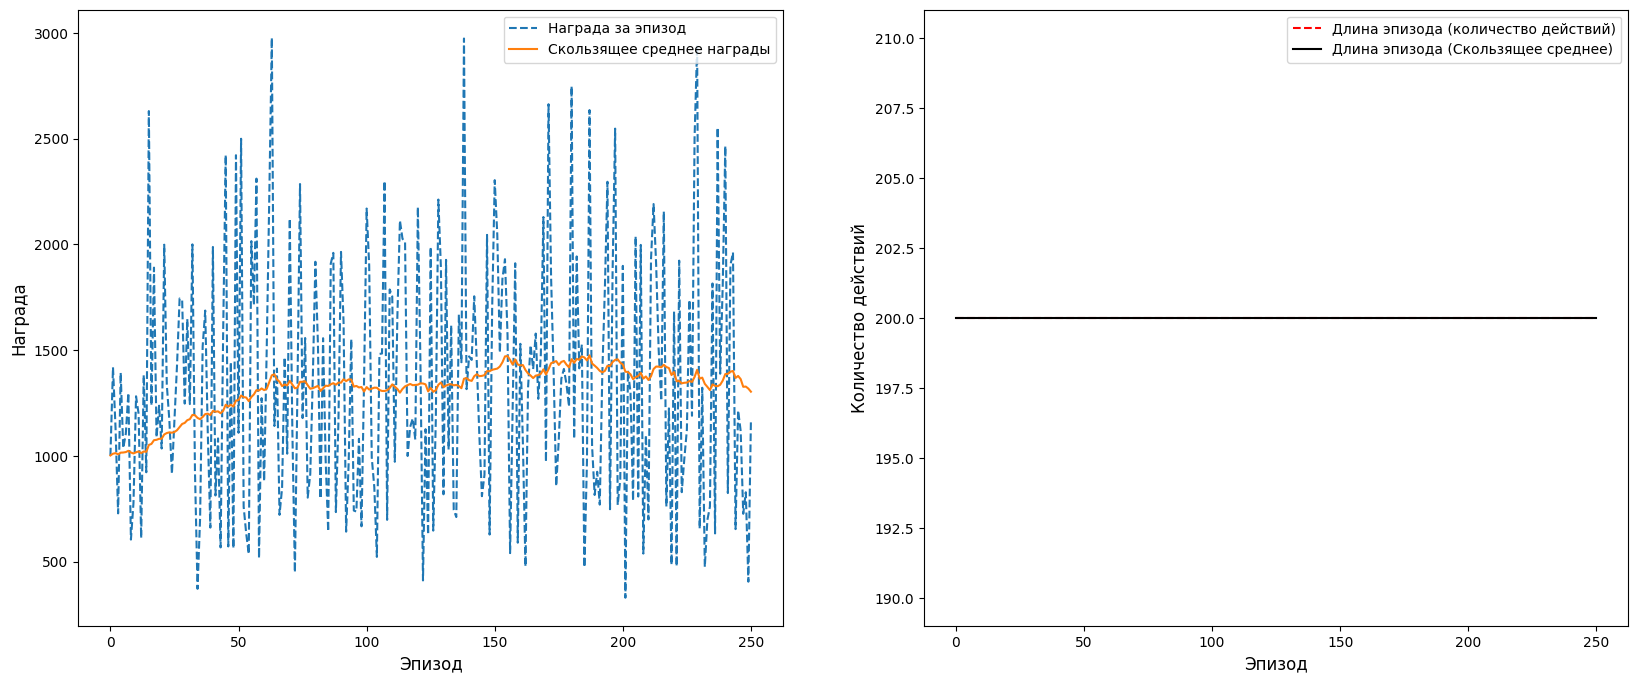

episode: 250/1500, score: 1168.2319939645822, dur: 200, average: 1302.95 
episode: 251/1500, score: 931.3882311435009, dur: 200, average: 1315.00 
episode: 252/1500, score: 2514.7520141254063, dur: 200, average: 1337.25 
episode: 253/1500, score: 436.8139689704549, dur: 200, average: 1320.00 
episode: 254/1500, score: 885.8966340776533, dur: 200, average: 1321.98 
episode: 255/1500, score: 881.2483867277479, dur: 200, average: 1298.84 
episode: 256/1500, score: 1544.7818627981178, dur: 200, average: 1313.59 
episode: 257/1500, score: 1183.1419417940197, dur: 200, average: 1297.32 
episode: 258/1500, score: 2297.7920680605166, dur: 200, average: 1332.52 
episode: 259/1500, score: 1599.7794261784293, dur: 200, average: 1342.57 
episode: 260/1500, score: 1521.1832910572411, dur: 200, average: 1359.02 
episode: 261/1500, score: 1469.8605885314464, dur: 200, average: 1349.83 
episode: 262/1500, score: 777.794427194749, dur: 200, average: 1321.58 
episode: 263/1500, score: 523.7048658966614,

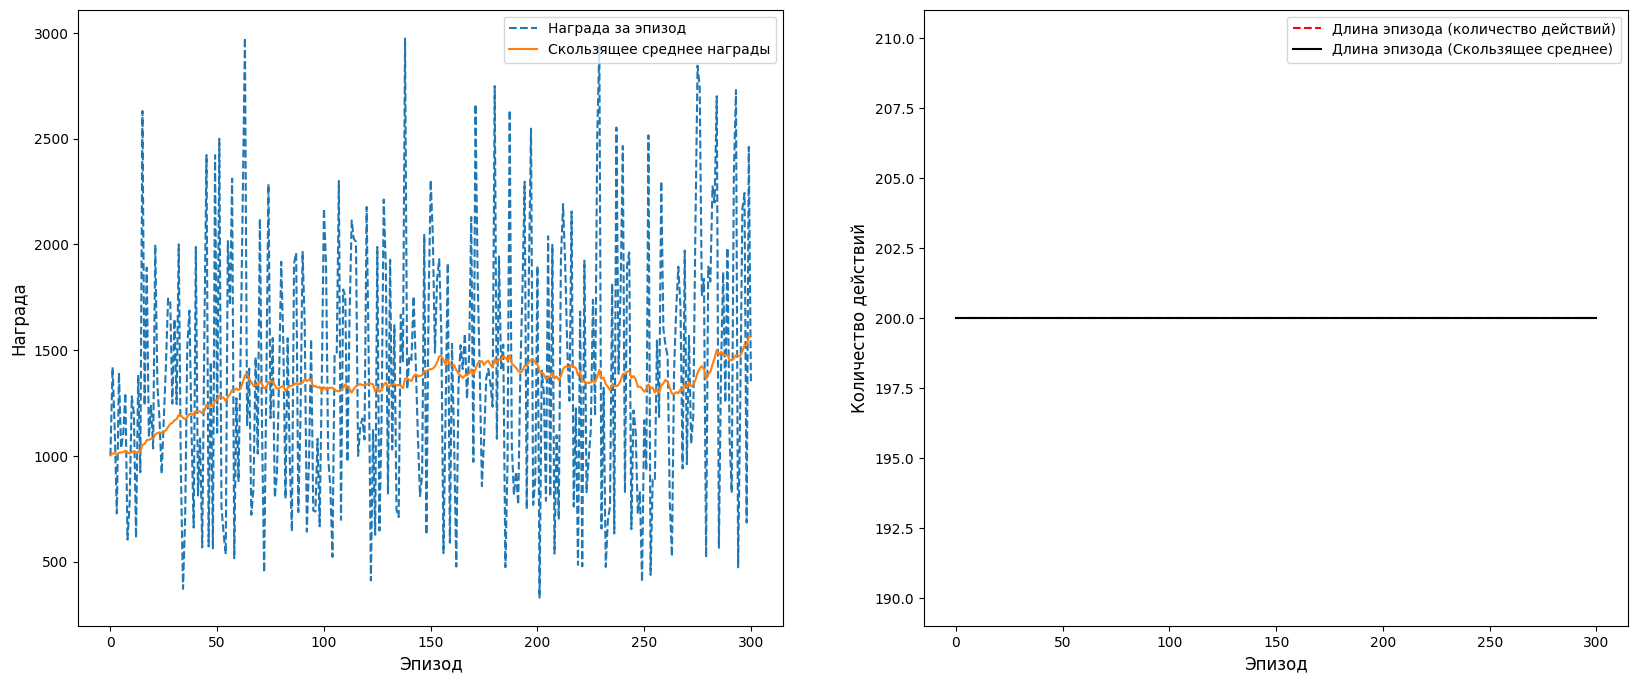

episode: 300/1500, score: 1342.8651318099583, dur: 200, average: 1565.70 SAVING
episode: 301/1500, score: 1275.0379885146685, dur: 200, average: 1572.57 SAVING
episode: 302/1500, score: 1197.1604414702597, dur: 200, average: 1546.22 
episode: 303/1500, score: 2696.657704997051, dur: 200, average: 1591.42 SAVING
episode: 304/1500, score: 2253.3237682218896, dur: 200, average: 1618.77 SAVING
episode: 305/1500, score: 2543.6352650726803, dur: 200, average: 1652.01 SAVING
episode: 306/1500, score: 614.210995090616, dur: 200, average: 1633.40 
episode: 307/1500, score: 518.2490626757499, dur: 200, average: 1620.11 
episode: 308/1500, score: 461.69736915001636, dur: 200, average: 1583.38 
episode: 309/1500, score: 2958.0628985422663, dur: 200, average: 1610.55 
episode: 310/1500, score: 1980.1662071695318, dur: 200, average: 1619.73 
episode: 311/1500, score: 2076.3768059368886, dur: 200, average: 1631.86 
episode: 312/1500, score: 2126.4761725615244, dur: 200, average: 1658.83 SAVING
episod

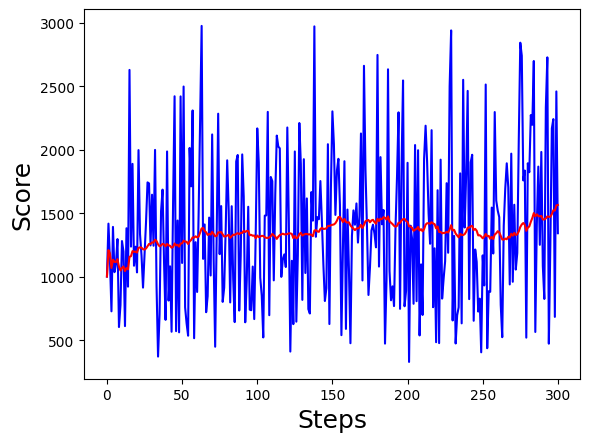

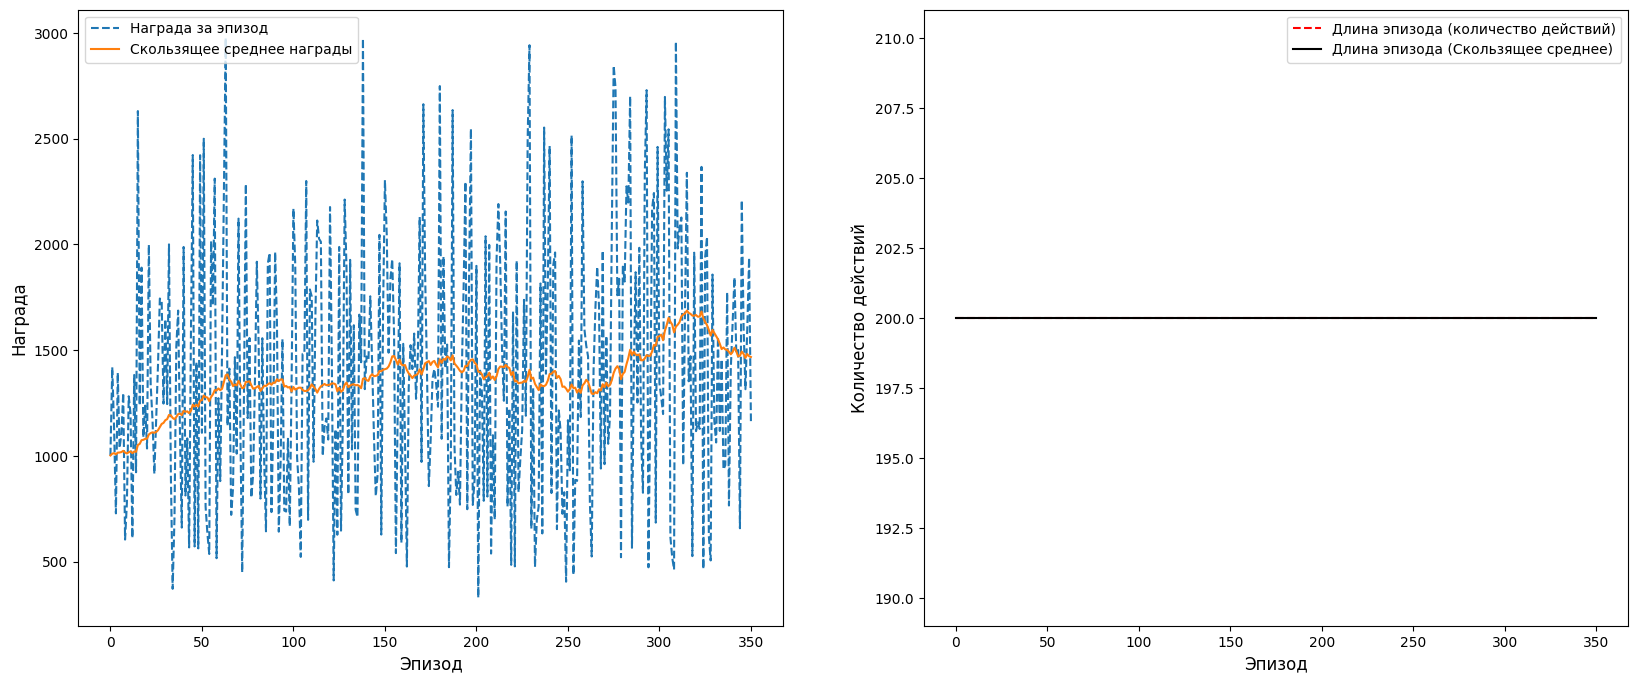

episode: 350/1500, score: 1163.7699460043223, dur: 200, average: 1466.92 
episode: 351/1500, score: 1825.9978461428545, dur: 200, average: 1477.94 
episode: 352/1500, score: 746.3338527886663, dur: 200, average: 1468.92 
episode: 353/1500, score: 832.4113966300501, dur: 200, average: 1431.64 
episode: 354/1500, score: 913.3621804840004, dur: 200, average: 1404.84 
episode: 355/1500, score: 2805.921121784195, dur: 200, average: 1410.08 
episode: 356/1500, score: 623.2946766122041, dur: 200, average: 1410.26 
episode: 357/1500, score: 1073.9328321578796, dur: 200, average: 1421.38 
episode: 358/1500, score: 1220.9587286306487, dur: 200, average: 1436.56 
episode: 359/1500, score: 1642.9404217888077, dur: 200, average: 1410.26 
episode: 360/1500, score: 989.6438433897856, dur: 200, average: 1390.45 
episode: 361/1500, score: 1989.034960832214, dur: 200, average: 1388.70 
episode: 362/1500, score: 1196.4115017490258, dur: 200, average: 1370.10 
episode: 363/1500, score: 1370.0378390458354,

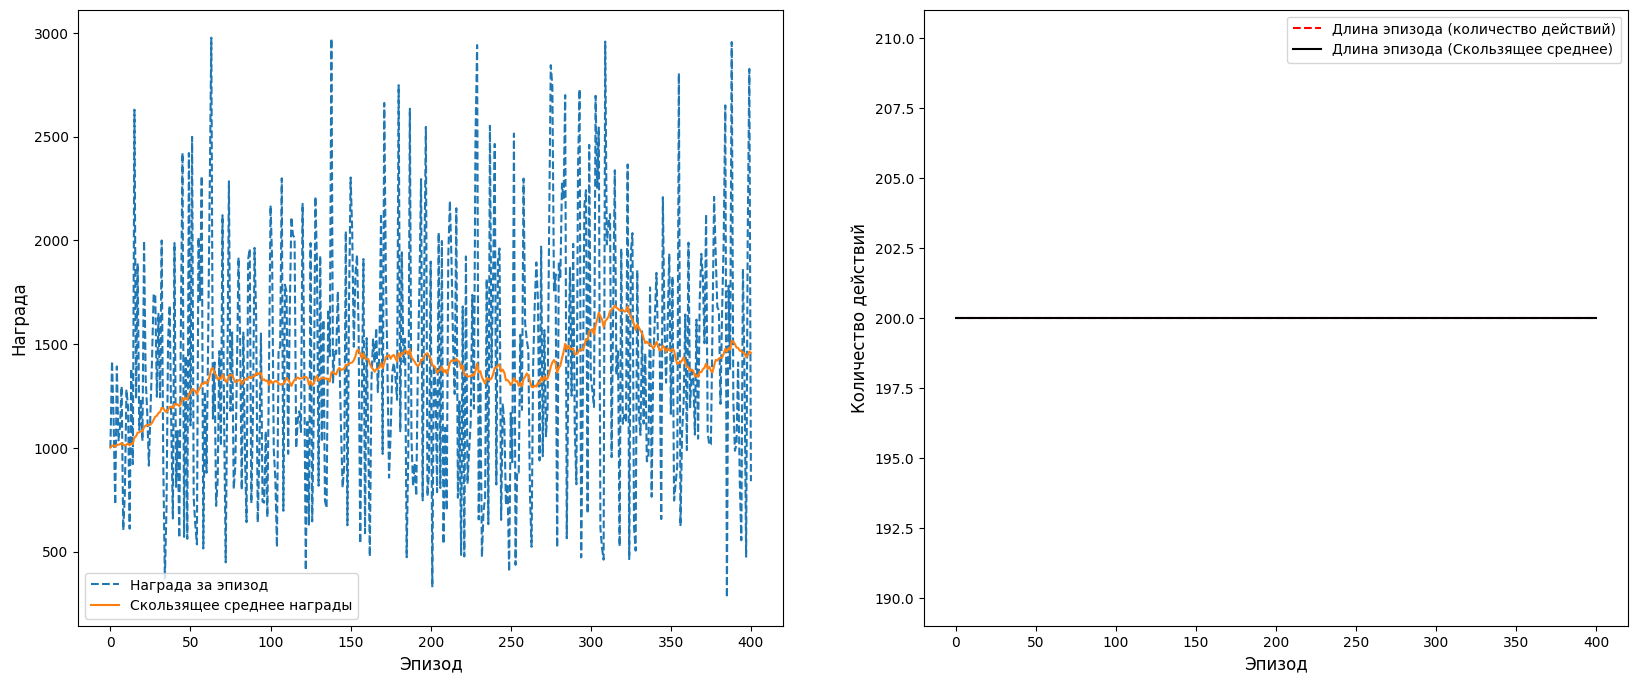

episode: 400/1500, score: 839.7678085211737, dur: 200, average: 1458.29 
episode: 401/1500, score: 531.6159118456198, dur: 200, average: 1432.40 
episode: 402/1500, score: 1934.5044355759455, dur: 200, average: 1456.17 
episode: 403/1500, score: 1645.3244274480312, dur: 200, average: 1472.42 
episode: 404/1500, score: 851.9735380982638, dur: 200, average: 1471.20 
episode: 405/1500, score: 2331.6720631046337, dur: 200, average: 1461.71 
episode: 406/1500, score: 2299.01526858157, dur: 200, average: 1495.23 
episode: 407/1500, score: 618.5288006490737, dur: 200, average: 1486.12 
episode: 408/1500, score: 1600.5092837804114, dur: 200, average: 1493.71 
episode: 409/1500, score: 2282.127912098076, dur: 200, average: 1506.49 
episode: 410/1500, score: 953.8561279532587, dur: 200, average: 1505.78 
episode: 411/1500, score: 2211.4575892005064, dur: 200, average: 1510.23 
episode: 412/1500, score: 1587.8337442845805, dur: 200, average: 1518.05 
episode: 413/1500, score: 455.2126430585304, d

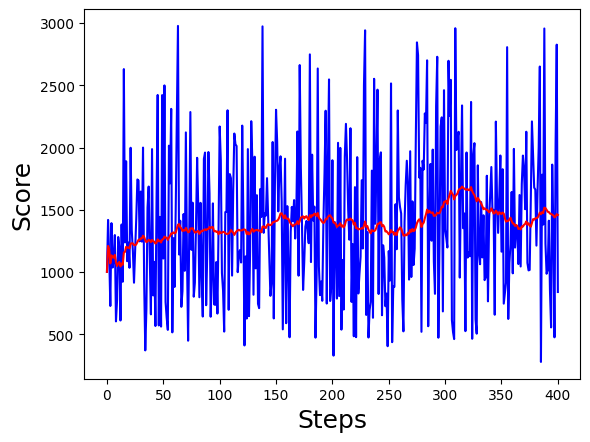

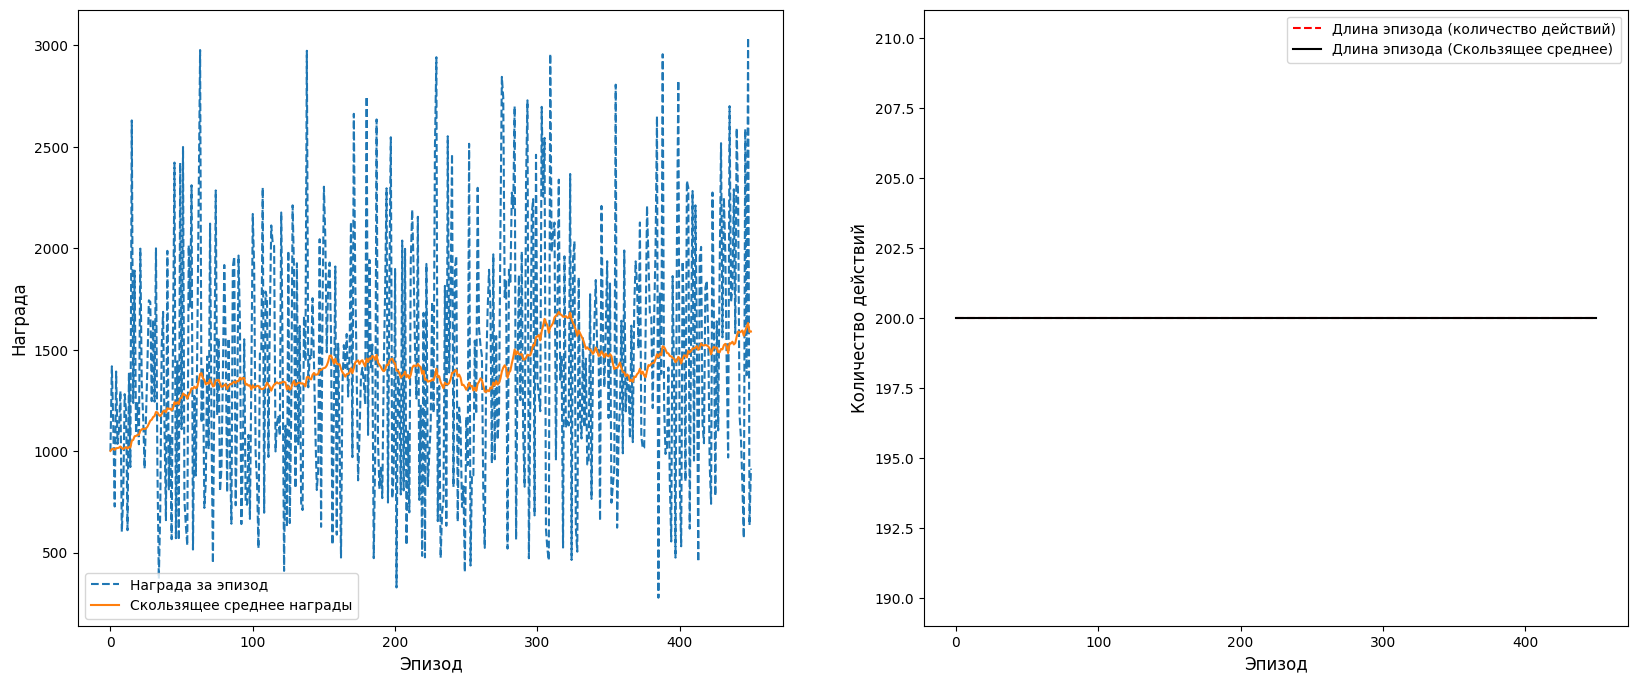

episode: 450/1500, score: 914.150233291366, dur: 200, average: 1589.56 
episode: 451/1500, score: 2250.238697557961, dur: 200, average: 1623.93 
episode: 452/1500, score: 2622.084246148006, dur: 200, average: 1637.68 
episode: 453/1500, score: 883.8456531448173, dur: 200, average: 1622.45 
episode: 454/1500, score: 1167.928781484079, dur: 200, average: 1628.77 
episode: 455/1500, score: 2226.1491963872686, dur: 200, average: 1626.66 
episode: 456/1500, score: 577.2091127582826, dur: 200, average: 1592.23 
episode: 457/1500, score: 930.7865084192599, dur: 200, average: 1598.47 
episode: 458/1500, score: 1299.4820129606524, dur: 200, average: 1592.45 
episode: 459/1500, score: 540.6269794170839, dur: 200, average: 1557.62 
episode: 460/1500, score: 1075.579473919447, dur: 200, average: 1560.06 
episode: 461/1500, score: 2085.9159992687637, dur: 200, average: 1557.55 
episode: 462/1500, score: 1488.1386009801645, dur: 200, average: 1555.55 
episode: 463/1500, score: 1869.931067845755, dur

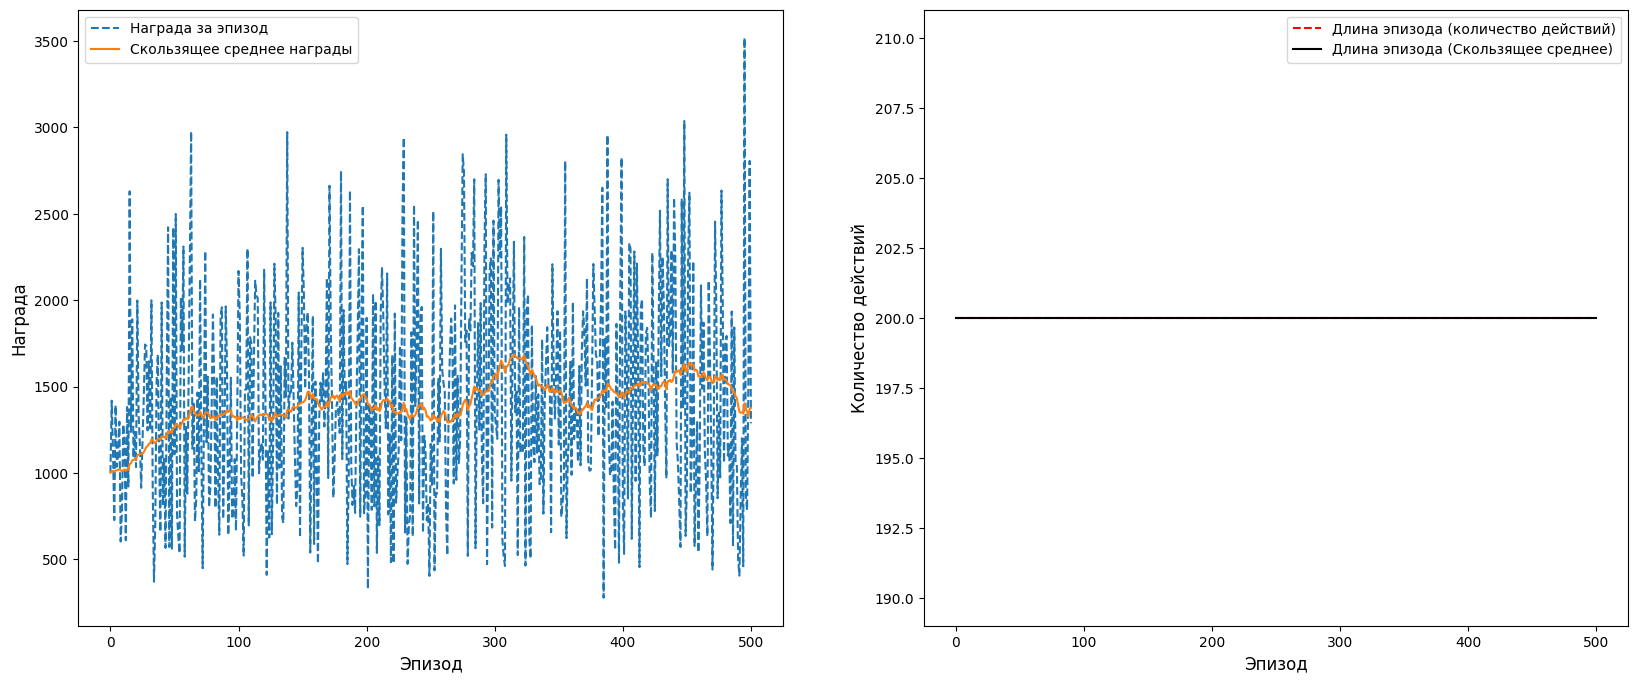

episode: 500/1500, score: 1287.6583475936059, dur: 200, average: 1376.89 
episode: 501/1500, score: 2095.32731273066, dur: 200, average: 1373.79 
episode: 502/1500, score: 884.4257801756612, dur: 200, average: 1339.04 
episode: 503/1500, score: 1755.0531143788248, dur: 200, average: 1356.46 
episode: 504/1500, score: 1368.2033803088416, dur: 200, average: 1360.47 
episode: 505/1500, score: 999.2800905929471, dur: 200, average: 1335.93 
episode: 506/1500, score: 1664.849062814028, dur: 200, average: 1357.68 
episode: 507/1500, score: 2357.5128227530513, dur: 200, average: 1386.22 
episode: 508/1500, score: 1258.2901147106895, dur: 200, average: 1385.39 
episode: 509/1500, score: 1200.6587569476324, dur: 200, average: 1398.59 
episode: 510/1500, score: 1541.7152163472565, dur: 200, average: 1407.92 
episode: 511/1500, score: 1609.1280425753212, dur: 200, average: 1398.38 
episode: 512/1500, score: 1291.557440887118, dur: 200, average: 1394.45 
episode: 513/1500, score: 832.1084636882006,

KeyboardInterrupt: 

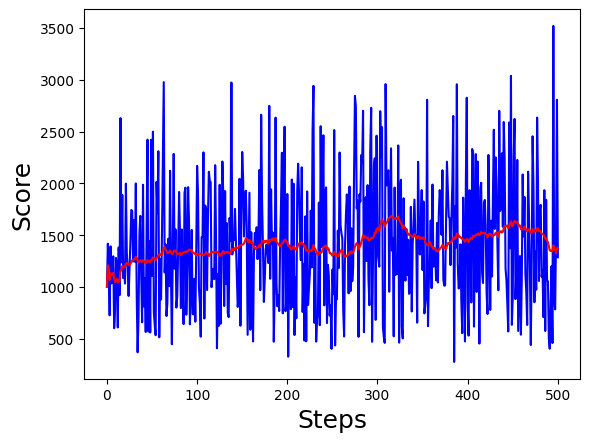

In [8]:
agent.reset()

agent.run(1500)
